# Test API

To test the API submission process

In [139]:
import traceback
import numpy as np
import pandas as pd
import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

## Version

In [140]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

version = 27

## get_features

In [141]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)

def upper_shadow(df):
    return ta.SUB(df['High'], np.maximum(df['Close'], df['Open']))

def lower_shadow(df):
    return ta.SUB(np.minimum(df['Close'], df['Open']), df['Low'] )

def lag_features(df):
    #Close-log-return
    df['lrtn_close_5'] = log_return(df['Close'],periods=5)
    df['lrtn_close_15'] = log_return(df['Close'],periods=15)
    df['lrtn_index_5'] = log_return(df['Crypto_Index'],periods=5)
    df['lrtn_index_15'] = log_return(df['Crypto_Index'],periods=15)
    
    #lr_mkt_resid sma
    df['lr_mkt_resid_sma'] = ta.SMA(df['lr_mkt_resid'],5)
    
    #15minutes-volume-sum/delta, on-balance-volume
    df['vol_sum_15'] = ta.SMA(df['Volume'],15)*15
    df['vol_delta_15'] = df['vol_sum_15'].diff()
    df['vol_pressure_1']=np.sign(df['Close'].diff(1)) * df['Volume']
    df['vol_pressure_15']=ta.MULT(np.sign(df['Close'].diff(15)), df['vol_sum_15'])
    
    #tech analysis indicators
    df['willr'] = ta.WILLR(df['High'], df['Low'],df['Close'], timeperiod=15)
    df['adx'] = ta.ADX(df['High'], df['Low'],df['Close'],timeperiod=15)
    df['DI_plus'] = ta.PLUS_DI(df['High'], df['Low'],df['Close'], timeperiod=14)
    df['DI_minus'] = ta.MINUS_DI(df['High'], df['Low'],df['Close'], timeperiod=14)
    df['ROCP'] =ta.ROCP(df['Open'])
    df['momentam'] =ta.MOM(df['Open'])
    df['APO'] =ta.APO(df['Open'])
    df['PPO'] =ta.PPO(df['Open'])
    df['CMO'] =ta.CMO(df['Open'])
    df['MIDPOINT'] =ta.MIDPOINT(df['Open'])
    df['TRENDLINE'] =ta.HT_TRENDLINE(df['Open'])
    
    df['rsi_15'] = ta.RSI(df['Close'], timeperiod=15)
    df['macd_15_30'],df['macd_signal'], df['macd_hist'] = ta.MACD(df['Close'], fastperiod=15, slowperiod=30, signalperiod=5)
    band_up, mid_band, band_down = ta.BBANDS(df['Close'], timeperiod=15, nbdevup=2, nbdevdn=2, matype=0)
    df['close_bollinger_up_15'] = ta.SUB(band_up, df['Close'])
    df['close_bollinger_down_15'] = ta.SUB(df['Close'], band_down)

def get_features(df_feat):
    '''
    df_feat must have [Crypto_Index, lr_mkt_resid]
    '''
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    lag_features(df_feat)
    return df_feat

## load models

In [142]:
from os.path import exists
def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models = model_reload_train(param_version=version)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

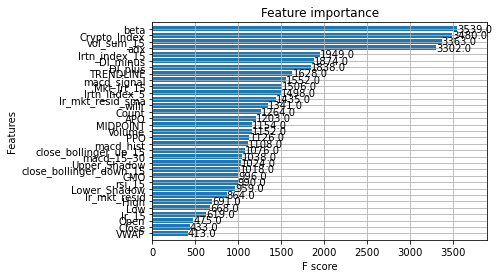

In [143]:
xgb.plot_importance(models[13],height=0.8)

## API submission

In [144]:
start = datestring_to_timestamp('2021-06-13T00:00:00')
#end = datestring_to_timestamp('2021-09-21T00:00:00')
end = datestring_to_timestamp('2021-06-13T01:00:00')

train_df = read_csv_slice(file_path='./data/train.csv', 
                          use_window=[start, end])

In [145]:
def beta(df, window=60): 
    b = (ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(window).mean())/(ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(window).mean())
    return b
def beta_1(df):
    b = (ta.MULT(df.Mkt_lrt_15,df.lr_15).mean())/(ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).mean())
    return b

def lr_mkt_resid(df):
    return ta.SUB(df.lr_15, ta.MULT(df.beta, df.Mkt_lrt_15))

In [146]:
######################################################
pre_minute=65+15
add_weight_map = dict(zip(df_asset_details.Asset_ID, 
                        df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute):,:]
#clean VWAP
sup_train.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
sup_train['VWAP']=sup_train['VWAP'].fillna((sup_train['High']+sup_train['Low'])/2)
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)
#######################################add lr_15,mkt_lr_15,crypto_index
lr_15 = sup_train.groupby('Asset_ID').apply( 
        lambda x: log_return(x[['Close']],15)
        )
sup_train['lr_15'] = lr_15['Close']

mkt_lr_15 = sup_train.groupby('timestamp').apply( 
    lambda x: x[["lr_15", "Close"]].multiply(x["Weight"], axis="index").sum()
    )
mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
firsts = sup_train.index.get_level_values('timestamp')
sup_train[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values

ddd = sup_train.groupby("Asset_ID").apply(lambda x: beta(x)).rename("beta").to_frame().reset_index(0,drop=True)
ddd = ddd.replace([np.nan,np.inf,-np.inf], 0)
sup_train= sup_train.merge(ddd, on =['timestamp','Asset_ID'],how='left')
sup_train['lr_mkt_resid'] = lr_mkt_resid(sup_train)
sup_train

Count          Open          High           Low  \
timestamp  Asset_ID                                                     
1641768060 1          935.0  42394.280871  42418.500000  42354.230000   
           2           13.0    380.255000    380.440000    380.190000   
           10           4.0   2132.585000   2133.000000   2132.170000   
           9           32.0    132.093000    132.140000    132.000000   
           11          62.0    190.114000    190.370000    189.550000   
...                     ...           ...           ...           ...   
1641772800 2          106.0    376.696667    376.950000    376.000000   
           1         2111.0  41860.168571  41877.700000  41766.700000   
           0          288.0    438.722333    438.800000    437.700000   
           12         112.0      0.261055      0.261185      0.260474   
           13         118.0      0.066109      0.066130      0.066058   

                            Close        Volume          VWAP    Weight  \
timestamp  Asset_ID                                                       
1641768060 1         42374.782570  1.646182e+01  42385.676787  0.165850   
           2           380.282500  6.205223e+00    380.268328  0.058657   
           10         2132.585000  3.150510e-01   2132.621276  0.026874   
           9           132.089200  3.639176e+01    132.078360  0.058657   
           11          190.052000  1.334774e+02    190.084335  0.039370   
...                           ...           ...           ...       ...   
1641772800 2           376.480000  1.443180e+02    376.560393  0.058657   
           1         41823.085714  8.982209e+01  41830.240059  0.165850   
           0           437.990333  4.016819e+02    438.278705  0.105286   
           12            0.260682  1.187581e+05      0.260913  0.050867   
           13            0.066082  1.265238e+06      0.066086  0.043830   

                        lr_15  Mkt_lrt_15  Crypto_Index      beta  \
timestamp  Asset_ID                                                 
1641768060 1              NaN    0.000000   7630.654122  0.000000   
           2              NaN    0.000000   7630.654122  0.000000   
           10             NaN    0.000000   7630.654122  0.000000   
           9              NaN    0.000000   7630.654122  0.000000   
           11             NaN    0.000000   7630.654122  0.000000   
...                       ...         ...           ...       ...   
1641772800 2        -0.002764   -0.003263   7532.261935  0.941457   
           1        -0.002324   -0.003263   7532.261935  1.083641   
           0        -0.002281   -0.003263   7532.261935  0.753114   
           12       -0.003568   -0.003263   7532.261935  0.938562   
           13       -0.003493   -0.003263   7532.261935  0.772317   

                     lr_mkt_resid  
timestamp  Asset_ID                
1641768060 1                  NaN  
           2                  NaN  
           10                 NaN  
           9                  NaN  
           11                 NaN  
...                           ...  
1641772800 2             0.000308  
           1             0.001212  
           0             0.000177  
           12           -0.000505  
           13           -0.000973  

[1120 rows x 13 columns]

In [147]:
from sys import stdout

################################################################################################
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for (df_test, df_pred) in myapi:
    stdout.write(f"\r{df_test.timestamp.values[0]}")
    stdout.flush()
    ######################################df_test info
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    test_timestamp = df_test.timestamp.values[0]
    timestamp_list = sup_train.index.get_level_values('timestamp').unique().values
    timestamp_list = np.append(timestamp_list,test_timestamp)
    #######################################format df_test
    df_test.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
    df_test['VWAP']=df_test['VWAP'].fillna((df_test['High']+df_test['Low'])/2)
    ###add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ###fillin missing assets as nan
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    ########################################concat to sup_train, add lr_15,mkt_lr_15,crypto_index
    sup_train = pd.concat([sup_train,df_test.drop('row_id',axis=1)],join='outer')
    test_lr_15 = sup_train.loc[timestamp_list[[-16,-1]]].groupby('Asset_ID').apply(
        lambda x: np.log(x[['Close']]).diff()
    )
    sup_train.loc[test_timestamp, 'lr_15'] = test_lr_15.loc[test_timestamp,'Close'].values
    sup_train.loc[test_timestamp, ['Mkt_lrt_15','Crypto_Index']] = sup_train.loc[test_timestamp, ["lr_15", "Close"]].multiply(sup_train.loc[test_timestamp,"Weight"], axis="index").sum().values
    #########################################fill in missing assets as forward
    if num_asset_test <14:
        #ffill in missing
        sup_train = sup_train.reset_index('Asset_ID').groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill"))
        sup_train = sup_train.set_index('Asset_ID', append=True).iloc[14:,:]
    else:
        sup_train = sup_train.iloc[14:,:]
    #########################################add beta with window=60
    df_beta = sup_train.iloc[-(14*60):,:]
    ddd = df_beta.groupby("Asset_ID").apply(lambda x: beta_1(x)).rename("beta").to_frame()
    ddd = ddd.replace([np.nan,np.inf,-np.inf], 0)
    sup_train.loc[test_timestamp, 'beta'] = ddd['beta'].values
    sup_train.loc[test_timestamp,'lr_mkt_resid'] = lr_mkt_resid(sup_train.loc[test_timestamp]).values
    sup_train2 = sup_train.copy()
    
    #######################################add features to test timestamp
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x)
    ).loc[test_timestamp]

    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)


time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/myapi.init_num_times}')
print(f'Submission time estimate {129600*time_elapsed/myapi.init_num_times}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
1623545940Time elapsed total (hh:mm:ss.ms) 0:00:05.693206
time elapsed per iteration 0:00:00.094887
Submission time estimate 3:24:57.324960


In [148]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is 0.024


In [149]:
df_pred

,row_id,Target
22222520,22222520,0.000943
22222521,22222521,0.001331
22222522,22222522,0.000199
22222523,22222523,0.000253
22222524,22222524,-0.002814
22222525,22222525,0.000863
22222526,22222526,0.000869
22222527,22222527,-0.000203
22222528,22222528,-0.002918
22222529,22222529,-0.002603
